In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
#import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
data_path = "../dataset/dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:25<00:00,  4.90it/s]


In [3]:
# let's see one of the conversations
#print(code2convos.keys())
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [4]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [5]:
# Get the answers
answers = []
code2answers = defaultdict(list)
for code , convos in code2convos.items():
    user_answers = []
    for conv in convos:
        if conv["role"] == "assistant":
            answers.append(conv["text"])
            user_answers.append(conv["text"])
    code2answers[code] = user_answers

In [6]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [7]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

BURADA PREPROCESSING YAPALIM ÖDEVDEKİ GİBİ (STOP WORD ÇIKARMA ROOT ALMA VS VS)

Starting PreProcessing

In [8]:
prompts

["Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n",
 'Provide Python code to understand a dataset using Pandas. Find the shape of the dataset, display variable names, display a summary of the dataset with the info() function, and show the first 5 rows using the head() function.\n',
 "You will preprocess the data now\n1. Check for missing values and handle them by either dropping or filling them with the most common values. Ensure that there is enough data for training the model. You can only use %80 data for training and %20 for testing\n2. Encode labels with mappings using the map function. Mapping names: \n   - sex_map = {'female': 1, 'male': 0}\n   - island_map = {'Biscoe': 1, 'Dream': 2, 'Torgensen': 3}\n   - diet_map = {'fish': 1, 'krill': 2, 'squid': 3, 'parent

In [9]:
def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser').get_text()

    return soup

prompts = [remove_html(text) for text in prompts]

prompts


C:\Users\cagri\AppData\Local\Temp\ipykernel_14280\961614451.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser').get_text()


["Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n",
 'Provide Python code to understand a dataset using Pandas. Find the shape of the dataset, display variable names, display a summary of the dataset with the info() function, and show the first 5 rows using the head() function.\n',
 "You will preprocess the data now\n1. Check for missing values and handle them by either dropping or filling them with the most common values. Ensure that there is enough data for training the model. You can only use %80 data for training and %20 for testing\n2. Encode labels with mappings using the map function. Mapping names: \n   - sex_map = {'female': 1, 'male': 0}\n   - island_map = {'Biscoe': 1, 'Dream': 2, 'Torgensen': 3}\n   - diet_map = {'fish': 1, 'krill': 2, 'squid': 3, 'parent

In [10]:
# Convert to lower case
def convert2lowercase(text):
    return text.lower()


prompts = [convert2lowercase(text) for text in prompts]

prompts


["load a csv file into a pandas in python. the file is named 'cs412_hw1_dataset.csv' and contains columns like 'species', 'island', 'sex', 'diet', 'year', 'life stage', 'body mass (g)', 'bill length (mm)', 'bill depth (mm)', 'flipper length (mm)', and 'health metrics'. \n",
 'provide python code to understand a dataset using pandas. find the shape of the dataset, display variable names, display a summary of the dataset with the info() function, and show the first 5 rows using the head() function.\n',
 "you will preprocess the data now\n1. check for missing values and handle them by either dropping or filling them with the most common values. ensure that there is enough data for training the model. you can only use %80 data for training and %20 for testing\n2. encode labels with mappings using the map function. mapping names: \n   - sex_map = {'female': 1, 'male': 0}\n   - island_map = {'biscoe': 1, 'dream': 2, 'torgensen': 3}\n   - diet_map = {'fish': 1, 'krill': 2, 'squid': 3, 'parent

In [11]:
import string

def remove_punc(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

prompts = [remove_punc(text) for text in prompts]

prompts

['load a csv file into a pandas in python the file is named cs412hw1datasetcsv and contains columns like species island sex diet year life stage body mass g bill length mm bill depth mm flipper length mm and health metrics \n',
 'provide python code to understand a dataset using pandas find the shape of the dataset display variable names display a summary of the dataset with the info function and show the first 5 rows using the head function\n',
 'you will preprocess the data now\n1 check for missing values and handle them by either dropping or filling them with the most common values ensure that there is enough data for training the model you can only use 80 data for training and 20 for testing\n2 encode labels with mappings using the map function mapping names \n    sexmap  female 1 male 0\n    islandmap  biscoe 1 dream 2 torgensen 3\n    dietmap  fish 1 krill 2 squid 3 parental 4\n    lifestagemap  chick 1 juvenile 2 adult 3\n    healthmetricsmap  healthy 1 overweight 2 underweight 

In [12]:
from nltk.tokenize import word_tokenize

test = 'Hello! this is a test'
print(f"Tokenized sentence: {word_tokenize(test)}")

Tokenized sentence: ['Hello', '!', 'this', 'is', 'a', 'test']


In [13]:
# Tokenize the review texts
def tokenize(text):
    return word_tokenize(text)

prompts = [tokenize(text) for text in prompts]

prompts

[['load',
  'a',
  'csv',
  'file',
  'into',
  'a',
  'pandas',
  'in',
  'python',
  'the',
  'file',
  'is',
  'named',
  'cs412hw1datasetcsv',
  'and',
  'contains',
  'columns',
  'like',
  'species',
  'island',
  'sex',
  'diet',
  'year',
  'life',
  'stage',
  'body',
  'mass',
  'g',
  'bill',
  'length',
  'mm',
  'bill',
  'depth',
  'mm',
  'flipper',
  'length',
  'mm',
  'and',
  'health',
  'metrics'],
 ['provide',
  'python',
  'code',
  'to',
  'understand',
  'a',
  'dataset',
  'using',
  'pandas',
  'find',
  'the',
  'shape',
  'of',
  'the',
  'dataset',
  'display',
  'variable',
  'names',
  'display',
  'a',
  'summary',
  'of',
  'the',
  'dataset',
  'with',
  'the',
  'info',
  'function',
  'and',
  'show',
  'the',
  'first',
  '5',
  'rows',
  'using',
  'the',
  'head',
  'function'],
 ['you',
  'will',
  'preprocess',
  'the',
  'data',
  'now',
  '1',
  'check',
  'for',
  'missing',
  'values',
  'and',
  'handle',
  'them',
  'by',
  'either',
  'dr

In [14]:
# Remove stop words
from nltk.corpus import stopwords

stopwordsList= set(stopwords.words('english'))

def remove_stopwords(tokenized_text):
    return [word for word in tokenized_text if word not in stopwordsList]

prompts = [remove_stopwords(text) for text in prompts]

prompts


[['load',
  'csv',
  'file',
  'pandas',
  'python',
  'file',
  'named',
  'cs412hw1datasetcsv',
  'contains',
  'columns',
  'like',
  'species',
  'island',
  'sex',
  'diet',
  'year',
  'life',
  'stage',
  'body',
  'mass',
  'g',
  'bill',
  'length',
  'mm',
  'bill',
  'depth',
  'mm',
  'flipper',
  'length',
  'mm',
  'health',
  'metrics'],
 ['provide',
  'python',
  'code',
  'understand',
  'dataset',
  'using',
  'pandas',
  'find',
  'shape',
  'dataset',
  'display',
  'variable',
  'names',
  'display',
  'summary',
  'dataset',
  'info',
  'function',
  'show',
  'first',
  '5',
  'rows',
  'using',
  'head',
  'function'],
 ['preprocess',
  'data',
  '1',
  'check',
  'missing',
  'values',
  'handle',
  'either',
  'dropping',
  'filling',
  'common',
  'values',
  'ensure',
  'enough',
  'data',
  'training',
  'model',
  'use',
  '80',
  'data',
  'training',
  '20',
  'testing',
  '2',
  'encode',
  'labels',
  'mappings',
  'using',
  'map',
  'function',
  'ma

In [15]:
# Apply Stemming
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')

def stemming(tokenized_text):
    joined_text = ' '.join(tokenized_text)
    
    tokenized = word_tokenize(joined_text)
    
    stemmed = [stemmer.stem(word) for word in tokenized]
    return stemmed

prompts = [stemming(text) for text in prompts]

prompts

[['load',
  'csv',
  'file',
  'panda',
  'python',
  'file',
  'name',
  'cs412hw1datasetcsv',
  'contain',
  'column',
  'like',
  'speci',
  'island',
  'sex',
  'diet',
  'year',
  'life',
  'stage',
  'bodi',
  'mass',
  'g',
  'bill',
  'length',
  'mm',
  'bill',
  'depth',
  'mm',
  'flipper',
  'length',
  'mm',
  'health',
  'metric'],
 ['provid',
  'python',
  'code',
  'understand',
  'dataset',
  'use',
  'panda',
  'find',
  'shape',
  'dataset',
  'display',
  'variabl',
  'name',
  'display',
  'summari',
  'dataset',
  'info',
  'function',
  'show',
  'first',
  '5',
  'row',
  'use',
  'head',
  'function'],
 ['preprocess',
  'data',
  '1',
  'check',
  'miss',
  'valu',
  'handl',
  'either',
  'drop',
  'fill',
  'common',
  'valu',
  'ensur',
  'enough',
  'data',
  'train',
  'model',
  'use',
  '80',
  'data',
  'train',
  '20',
  'test',
  '2',
  'encod',
  'label',
  'map',
  'use',
  'map',
  'function',
  'map',
  'name',
  'sexmap',
  'femal',
  '1',
  'mal

In [16]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cagri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cagri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Lemmatizer'ı başlat
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokenized_text):
    joined_text = ' '.join(tokenized_text)
    
    tokenized = word_tokenize(joined_text)
    
    lemmatized = [lemmatizer.lemmatize(word) for word in tokenized]
    return lemmatized

# Her bir metin üzerinde lemmatization uygula
prompts = [lemmatize_text(text) for text in prompts]

print(prompts)


[['load', 'csv', 'file', 'panda', 'python', 'file', 'name', 'cs412hw1datasetcsv', 'contain', 'column', 'like', 'speci', 'island', 'sex', 'diet', 'year', 'life', 'stage', 'bodi', 'mass', 'g', 'bill', 'length', 'mm', 'bill', 'depth', 'mm', 'flipper', 'length', 'mm', 'health', 'metric'], ['provid', 'python', 'code', 'understand', 'dataset', 'use', 'panda', 'find', 'shape', 'dataset', 'display', 'variabl', 'name', 'display', 'summari', 'dataset', 'info', 'function', 'show', 'first', '5', 'row', 'use', 'head', 'function'], ['preprocess', 'data', '1', 'check', 'miss', 'valu', 'handl', 'either', 'drop', 'fill', 'common', 'valu', 'ensur', 'enough', 'data', 'train', 'model', 'use', '80', 'data', 'train', '20', 'test', '2', 'encod', 'label', 'map', 'use', 'map', 'function', 'map', 'name', 'sexmap', 'femal', '1', 'male', '0', 'islandmap', 'bisco', '1', 'dream', '2', 'torgensen', '3', 'dietmap', 'fish', '1', 'krill', '2', 'squid', '3', 'parent', '4', 'lifestagemap', 'chick', '1', 'juvenil', '2', '

In [18]:
def joinThemAll(tokenized_text):
    return ' '.join(tokenized_text)


prompts = [joinThemAll(text) for text in prompts]

prompts

['load csv file panda python file name cs412hw1datasetcsv contain column like speci island sex diet year life stage bodi mass g bill length mm bill depth mm flipper length mm health metric',
 'provid python code understand dataset use panda find shape dataset display variabl name display summari dataset info function show first 5 row use head function',
 'preprocess data 1 check miss valu handl either drop fill common valu ensur enough data train model use 80 data train 20 test 2 encod label map use map function map name sexmap femal 1 male 0 islandmap bisco 1 dream 2 torgensen 3 dietmap fish 1 krill 2 squid 3 parent 4 lifestagemap chick 1 juvenil 2 adult 3 healthmetricsmap healthi 1 overweight 2 underweight 3 dataset name df',
 'alreadi provid code plea recreat part shuffl need 1 shuffl datafram name df 2 separ dataset featur matrix x target vector column healthmetr column includ x 3 split data train test set 80 data train 20 test ensur split random',
 'calcul visual correl featur pan

In [19]:
# FOR QUESTIONS

questions = [remove_html(text) for text in questions]

questions

['Initialize\n*   First make a copy of the notebook given to you as a starter.\n*   Make sure you choose Connect form upper right.\n*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.\n\n',
 'Load training dataset (5 pts)\n    *  Read the .csv file with the pandas library\n',
 'Understanding the dataset & Preprocessing (15 pts)\nUnderstanding the Dataset: (5 pts)\n> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)\n> - Display variable names (both dependent and independent).\n> - Display the summary of the dataset. (Hint: You can use the **info** function)\n> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)\nPreprocessing: (10 pts)\n\n> - Check if there are any missing values in the dataset. If there are, you can either drop the

In [20]:
questions = [convert2lowercase(text) for text in questions]

questions

['initialize\n*   first make a copy of the notebook given to you as a starter.\n*   make sure you choose connect form upper right.\n*   you may upload the data to the section on your left on colab, than right click on the .csv file and get the path of the file by clicking on "copy path". you will be using it when loading the data.\n\n',
 'load training dataset (5 pts)\n    *  read the .csv file with the pandas library\n',
 'understanding the dataset & preprocessing (15 pts)\nunderstanding the dataset: (5 pts)\n> - find the shape of the dataset (number of samples & number of attributes). (hint: you can use the **shape** function)\n> - display variable names (both dependent and independent).\n> - display the summary of the dataset. (hint: you can use the **info** function)\n> - display the first 5 rows from training dataset. (hint: you can use the **head** function)\npreprocessing: (10 pts)\n\n> - check if there are any missing values in the dataset. if there are, you can either drop the

In [21]:
questions = [remove_punc(text) for text in questions]

questions

['initialize\n   first make a copy of the notebook given to you as a starter\n   make sure you choose connect form upper right\n   you may upload the data to the section on your left on colab than right click on the csv file and get the path of the file by clicking on copy path you will be using it when loading the data\n\n',
 'load training dataset 5 pts\n      read the csv file with the pandas library\n',
 'understanding the dataset  preprocessing 15 pts\nunderstanding the dataset 5 pts\n  find the shape of the dataset number of samples  number of attributes hint you can use the shape function\n  display variable names both dependent and independent\n  display the summary of the dataset hint you can use the info function\n  display the first 5 rows from training dataset hint you can use the head function\npreprocessing 10 pts\n\n  check if there are any missing values in the dataset if there are you can either drop these values or fill it with most common values in corresponding rows

In [22]:
questions = [tokenize(text) for text in questions]

questions

[['initialize',
  'first',
  'make',
  'a',
  'copy',
  'of',
  'the',
  'notebook',
  'given',
  'to',
  'you',
  'as',
  'a',
  'starter',
  'make',
  'sure',
  'you',
  'choose',
  'connect',
  'form',
  'upper',
  'right',
  'you',
  'may',
  'upload',
  'the',
  'data',
  'to',
  'the',
  'section',
  'on',
  'your',
  'left',
  'on',
  'colab',
  'than',
  'right',
  'click',
  'on',
  'the',
  'csv',
  'file',
  'and',
  'get',
  'the',
  'path',
  'of',
  'the',
  'file',
  'by',
  'clicking',
  'on',
  'copy',
  'path',
  'you',
  'will',
  'be',
  'using',
  'it',
  'when',
  'loading',
  'the',
  'data'],
 ['load',
  'training',
  'dataset',
  '5',
  'pts',
  'read',
  'the',
  'csv',
  'file',
  'with',
  'the',
  'pandas',
  'library'],
 ['understanding',
  'the',
  'dataset',
  'preprocessing',
  '15',
  'pts',
  'understanding',
  'the',
  'dataset',
  '5',
  'pts',
  'find',
  'the',
  'shape',
  'of',
  'the',
  'dataset',
  'number',
  'of',
  'samples',
  'number',
 

In [23]:
questions = [remove_stopwords(text) for text in questions]

questions

[['initialize',
  'first',
  'make',
  'copy',
  'notebook',
  'given',
  'starter',
  'make',
  'sure',
  'choose',
  'connect',
  'form',
  'upper',
  'right',
  'may',
  'upload',
  'data',
  'section',
  'left',
  'colab',
  'right',
  'click',
  'csv',
  'file',
  'get',
  'path',
  'file',
  'clicking',
  'copy',
  'path',
  'using',
  'loading',
  'data'],
 ['load',
  'training',
  'dataset',
  '5',
  'pts',
  'read',
  'csv',
  'file',
  'pandas',
  'library'],
 ['understanding',
  'dataset',
  'preprocessing',
  '15',
  'pts',
  'understanding',
  'dataset',
  '5',
  'pts',
  'find',
  'shape',
  'dataset',
  'number',
  'samples',
  'number',
  'attributes',
  'hint',
  'use',
  'shape',
  'function',
  'display',
  'variable',
  'names',
  'dependent',
  'independent',
  'display',
  'summary',
  'dataset',
  'hint',
  'use',
  'info',
  'function',
  'display',
  'first',
  '5',
  'rows',
  'training',
  'dataset',
  'hint',
  'use',
  'head',
  'function',
  'preprocessing

In [24]:
questions = [stemming(text) for text in questions]

questions

[['initi',
  'first',
  'make',
  'copi',
  'notebook',
  'given',
  'starter',
  'make',
  'sure',
  'choos',
  'connect',
  'form',
  'upper',
  'right',
  'may',
  'upload',
  'data',
  'section',
  'left',
  'colab',
  'right',
  'click',
  'csv',
  'file',
  'get',
  'path',
  'file',
  'click',
  'copi',
  'path',
  'use',
  'load',
  'data'],
 ['load',
  'train',
  'dataset',
  '5',
  'pts',
  'read',
  'csv',
  'file',
  'panda',
  'librari'],
 ['understand',
  'dataset',
  'preprocess',
  '15',
  'pts',
  'understand',
  'dataset',
  '5',
  'pts',
  'find',
  'shape',
  'dataset',
  'number',
  'sampl',
  'number',
  'attribut',
  'hint',
  'use',
  'shape',
  'function',
  'display',
  'variabl',
  'name',
  'depend',
  'independ',
  'display',
  'summari',
  'dataset',
  'hint',
  'use',
  'info',
  'function',
  'display',
  'first',
  '5',
  'row',
  'train',
  'dataset',
  'hint',
  'use',
  'head',
  'function',
  'preprocess',
  '10',
  'pts',
  'check',
  'miss',
  'va

In [25]:
questions = [lemmatize_text(text) for text in questions]

print(questions)

[['initi', 'first', 'make', 'copi', 'notebook', 'given', 'starter', 'make', 'sure', 'choos', 'connect', 'form', 'upper', 'right', 'may', 'upload', 'data', 'section', 'left', 'colab', 'right', 'click', 'csv', 'file', 'get', 'path', 'file', 'click', 'copi', 'path', 'use', 'load', 'data'], ['load', 'train', 'dataset', '5', 'pt', 'read', 'csv', 'file', 'panda', 'librari'], ['understand', 'dataset', 'preprocess', '15', 'pt', 'understand', 'dataset', '5', 'pt', 'find', 'shape', 'dataset', 'number', 'sampl', 'number', 'attribut', 'hint', 'use', 'shape', 'function', 'display', 'variabl', 'name', 'depend', 'independ', 'display', 'summari', 'dataset', 'hint', 'use', 'info', 'function', 'display', 'first', '5', 'row', 'train', 'dataset', 'hint', 'use', 'head', 'function', 'preprocess', '10', 'pt', 'check', 'miss', 'valu', 'dataset', 'either', 'drop', 'valu', 'fill', 'common', 'valu', 'correspond', 'row', 'care', 'enough', 'data', 'train', 'model', 'encod', 'categor', 'label', 'map', 'given', 'cel

In [26]:
questions = [joinThemAll(text) for text in questions]

questions

['initi first make copi notebook given starter make sure choos connect form upper right may upload data section left colab right click csv file get path file click copi path use load data',
 'load train dataset 5 pt read csv file panda librari',
 'understand dataset preprocess 15 pt understand dataset 5 pt find shape dataset number sampl number attribut hint use shape function display variabl name depend independ display summari dataset hint use info function display first 5 row train dataset hint use head function preprocess 10 pt check miss valu dataset either drop valu fill common valu correspond row care enough data train model encod categor label map given cell hint use map function',
 'set x split data 5 pt shuffl dataset seper depend variabl x independ variabl column healthmetr rest x split train test set 80 20 respect',
 'featur correl 10 pt correl featur health 4 point calcul correl featur dataset highlight strong correl target variabl plot result heatmap featur select 3 point

End of PreProcessing

In [27]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [28]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

00  0000196  0000282  0000284  0000360  0000469  0000750  0000886  \
0  0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1  0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2  0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3  0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4  0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   0000991  0001  ...   yã   yä  zaman  zdã¼m  zero  zerodivisionerror  \
0      0.0   0.0  ...  0.0  0.0    0.0    0.0   0.0                0.0   
1      0.0   0.0  ...  0.0  0.0    0.0    0.0   0.0                0.0   
2      0.0   0.0  ...  0.0  0.0    0.0    0.0   0.0                0.0   
3      0.0   0.0  ...  0.0  0.0    0.0    0.0   0.0                0.0   
4      0.0   0.0  ...  0.0  0.0    0.0    0.0   0.0                0.0   

   zeroth  zipclassnam  zipnpuniquechildindicesaftersplit  ã¼nã¼yorum  
0     0.0          0.0                                0.0         0.0  
1     0.0          0.0                                0.0         0.0  
2     0.0          0.0                                0.0         0.0  
3     0.0          0.0                                0.0         0.0  
4     0.0          0.0                                0.0         0.0  

[5 rows x 6061 columns]

In [29]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    # code = "0031c86e-81f4-4eef-9e0e-28037abf9883", user_prompts = [prompt1, prompt2, ...]
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [30]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

00  0000196  0000282  0000284  0000360  0000469  0000750  0000886  \
0  0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1  0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2  0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3  0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4  0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   0000991  0001  ...   yã   yä  zaman  zdã¼m  zero  zerodivisionerror  \
0      0.0   0.0  ...  0.0  0.0    0.0    0.0   0.0                0.0   
1      0.0   0.0  ...  0.0  0.0    0.0    0.0   0.0                0.0   
2      0.0   0.0  ...  0.0  0.0    0.0    0.0   0.0                0.0   
3      0.0   0.0  ...  0.0  0.0    0.0    0.0   0.0                0.0   
4      0.0   0.0  ...  0.0  0.0    0.0    0.0   0.0                0.0   

   zeroth  zipclassnam  zipnpuniquechildindicesaftersplit  ã¼nã¼yorum  
0     0.0          0.0                                0.0         0.0  
1     0.0          0.0                                0.0         0.0  
2     0.0          0.0                                0.0         0.0  
3     0.0          0.0                                0.0         0.0  
4     0.0          0.0                                0.0         0.0  

[5 rows x 6061 columns]

In [31]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 6061)

In [32]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [33]:
questions[4]

'featur correl 10 pt correl featur health 4 point calcul correl featur dataset highlight strong correl target variabl plot result heatmap featur select 3 point select subset featur like strong predictor justifi choic base comput correl hypothet driver featur 3 point propos two hypothet featur could enhanc model predict accuraci explain might deriv expect impact show result correl target variabl note get get help gpt'

In [34]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

code       Q_0       Q_1       Q_2  \
0    0031c86e-81f4-4eef-9e0e-28037abf9883  0.129813  0.287018  0.193838   
1    0225686d-b825-4cac-8691-3a3a5343df2b  0.086766  0.278878  0.214735   
2    041f950b-c013-409a-a642-cffff60b9d4b  0.021408  0.033617  0.080447   
3    04f91058-d0f8-4324-83b2-19c671f433dc  0.060687  0.060104  0.121666   
4    089eb66d-4c3a-4f58-b98f-a3774a2efb34  0.184043  0.268752  0.264475   
..                                    ...       ...       ...       ...   
118  f24219d6-07f0-4baf-80ac-18475dc5b66f  0.061734  0.085695  0.099287   
119  f2f18684-4a16-4c05-a2d1-c0f96d1de869  0.093698  0.064857  0.132012   
120  f852596d-fdca-45aa-9050-d4f76ce6a53c  0.122246  0.413301  0.227604   
121  f8ec3336-fd48-4654-ad98-62ccfb96d096  0.122246  0.413301  0.231923   
122  fb8de815-224c-4d06-9fd4-7156d1a9920d  0.081193  0.274503  0.218371   

          Q_3       Q_4       Q_5       Q_6       Q_7       Q_8  
0    0.106710  0.069686  0.151696  0.016053  0.058891  0.063412  
1    0.140940  0.104137  0.168382  0.233423  0.127030  0.229035  
2    0.039986  0.133486  0.028385  0.066171  0.090294  0.038785  
3    0.220324  0.173462  0.111479  0.276453  0.129554  0.137191  
4    0.473466  0.113106  0.188264  0.219715  0.237225  0.205943  
..        ...       ...       ...       ...       ...       ...  
118  0.121026  0.176190  0.066328  0.212254  0.142455  0.241368  
119  0.214171  0.101378  0.221869  0.233089  0.155227  0.315464  
120  0.406406  0.140215  0.162276  0.147581  0.235885  0.220593  
121  0.206478  0.144653  0.291848  0.212254  0.159451  0.267012  
122  0.196549  0.111952  0.148744  0.192711  0.142267  0.259485  

[123 rows x 10 columns]

In [35]:
# Transform a TF-IDF vectorizer to the prompts and answers
prompts_answers_combined = [p + ' ' + a for p, a in zip(prompts, answers)]

vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts_answers_combined + questions)

questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
prompts_answers_TF_IDF = pd.DataFrame(vectorizer.transform(prompts_answers_combined).toarray(), columns=vectorizer.get_feature_names_out())
prompts_TF_IDF = pd.DataFrame(vectorizer.transform(prompts).toarray(), columns=vectorizer.get_feature_names_out())
prompts_TF_IDF.head()

00  000  000000  0000196  0000282  0000284  0000360  0000469  0000750  \
0  0.0  0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1  0.0  0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2  0.0  0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3  0.0  0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4  0.0  0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   0000886  ...  ã¼nã¼  ã¼nã¼yorum  ã¼reme  ã¼tlerini  ã¼zerinde  ã¼zerindeki  \
0      0.0  ...    0.0         0.0     0.0        0.0        0.0          0.0   
1      0.0  ...    0.0         0.0     0.0        0.0        0.0          0.0   
2      0.0  ...    0.0         0.0     0.0        0.0        0.0          0.0   
3      0.0  ...    0.0         0.0     0.0        0.0        0.0          0.0   
4      0.0  ...    0.0         0.0     0.0        0.0        0.0          0.0   

   ã¼zerinden  ã¼ã  ã¼ä   î¼  
0         0.0  0.0  0.0  0.0  
1         0.0  0.0  0.0  0.0  
2         0.0  0.0  0.0  0.0  
3         0.0  0.0  0.0  0.0  
4         0.0  0.0  0.0  0.0  

[5 rows x 14661 columns]

In [36]:
# vectorizer = TfidfVectorizer()
# vectorizer = vectorizer.fit(prompts_answers_combined + questions)

doc_term_matrix = vectorizer.fit_transform(prompts_answers_combined + questions)

cosine_sim_matrix = cosine_similarity(doc_term_matrix)
cosine_sim_matrix

array([[1.        , 0.33599422, 0.23371924, ..., 0.00637142, 0.00670502,
        0.02143176],
       [0.33599422, 1.        , 0.25194963, ..., 0.02196859, 0.02382607,
        0.05445466],
       [0.23371924, 0.25194963, 1.        , ..., 0.01475493, 0.06464778,
        0.00960834],
       ...,
       [0.00637142, 0.02196859, 0.01475493, ..., 1.        , 0.36779241,
        0.24409756],
       [0.00670502, 0.02382607, 0.06464778, ..., 0.36779241, 1.        ,
        0.2629258 ],
       [0.02143176, 0.05445466, 0.00960834, ..., 0.24409756, 0.2629258 ,
        1.        ]])

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

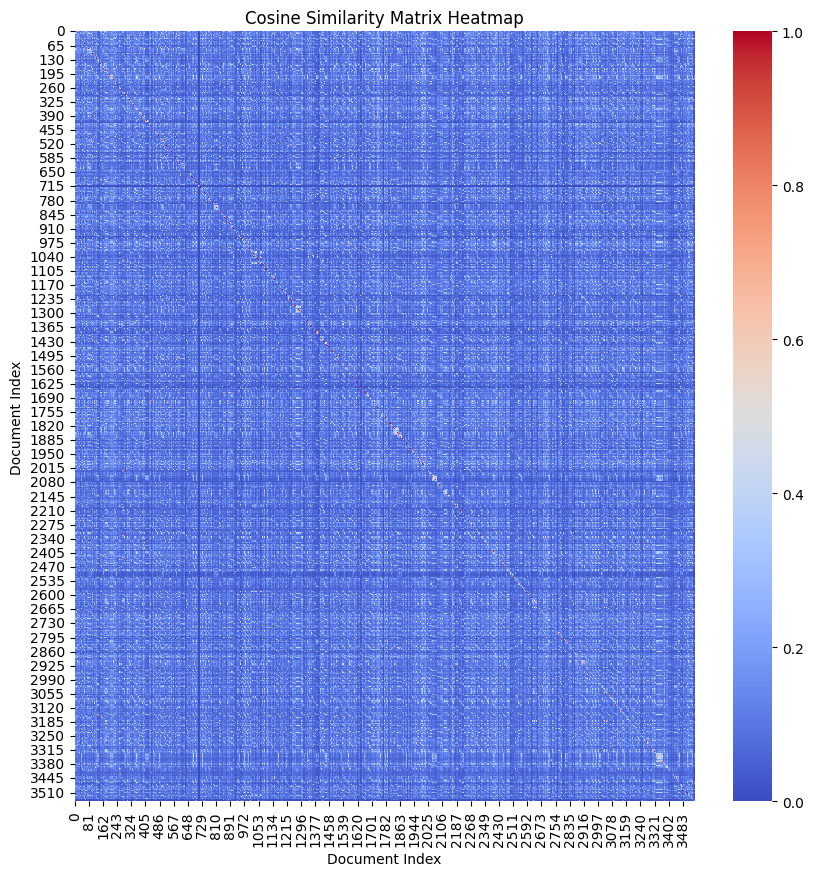

In [38]:
plt.figure(figsize=(10,10))
sns.heatmap(cosine_sim_matrix, annot=False, cmap='coolwarm')
plt.title("Cosine Similarity Matrix Heatmap")
plt.xlabel("Document Index")
plt.ylabel("Document Index")
plt.show()

In [79]:
# Scale the columns of the vectorized data
# from sklearn.discriminant_analysis import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# scaled_prompts_answers_TF_IDF = pd.DataFrame(scaler.fit_transform(prompts_answers_TF_IDF))
# scaled_prompts_TF_IDF = pd.DataFrame(scaler.fit_transform(prompts_TF_IDF))
# scaled_questions_TF_IDF = pd.DataFrame(scaler.fit_transform(questions_TF_IDF))

c:\Users\cagri\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\cagri\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


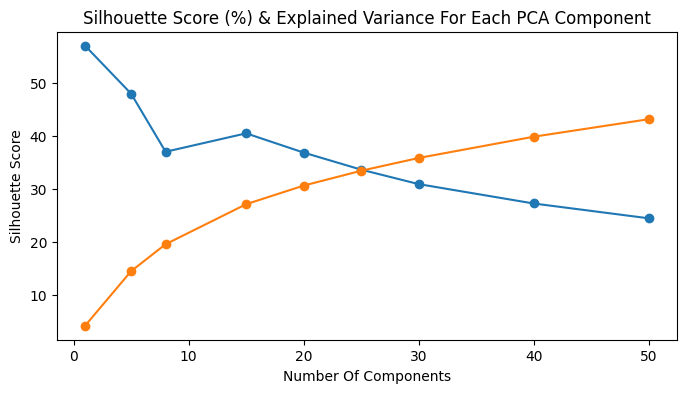

In [39]:
# Use PCA to reduce the dimensionality of the data
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
components = [1,5,8,15,20,25,30,40,50]
scores = []
exp_variance = []
for n in components:
    pca = PCA(n_components = n, random_state=43)
    pca.fit(pd.concat([prompts_TF_IDF, questions_TF_IDF]))
    pca_df = pca.transform(prompts_TF_IDF)
    exp_variance.append(pca.explained_variance_ratio_.sum() * 100)
    #print('Explained Variance Ratio For n_components={} is {}'.format(n,pca.explained_variance_ratio_.sum() * 100))

    #pca.fit(questions_TF_IDF)
    pca_questions_TF_IDF = pca.transform(questions_TF_IDF)

    kmeans = KMeans(n_clusters=9, random_state=43, init=pca_questions_TF_IDF, n_init=1).fit(pca_df)
    silhouette = silhouette_score(pca_df, kmeans.labels_)
    scores.append(silhouette * 100)

plt.figure(figsize=(8,4))
plt.plot(components, scores, marker='o')
plt.plot(components, exp_variance, marker='o')
plt.title('Silhouette Score (%) & Explained Variance For Each PCA Component'.format(n))
plt.xlabel('Number Of Components')
plt.ylabel('Silhouette Score')
plt.show()

In [40]:
# Use K-means clustering with number of clusters = 9 since we have 9 questions

kmeans_data = pd.concat([prompts_TF_IDF, questions_TF_IDF])

# Clustering on prompts_TF_IDF
kmeans = KMeans(n_clusters=9, random_state=0, init=questions_TF_IDF, n_init=1).fit(kmeans_data)

# Get the silhouette score
silhouette = silhouette_score(kmeans_data, kmeans.labels_)
print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.07201328789687199


(array([2040.,  119.,  314.,  152.,  365.,  165.,   93.,  140.,  165.]),
 array([0.        , 0.88888889, 1.77777778, 2.66666667, 3.55555556,
        4.44444444, 5.33333333, 6.22222222, 7.11111111, 8.        ]),
 <BarContainer object of 9 artists>)

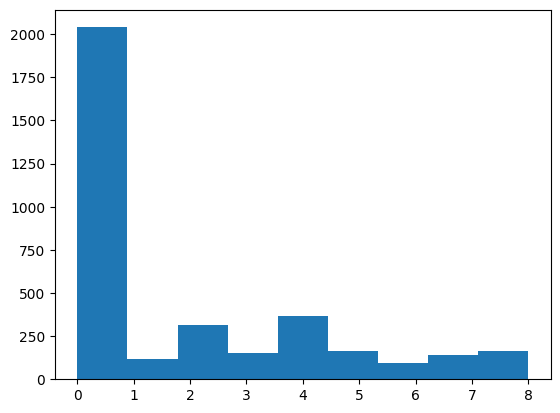

In [41]:
plt.hist(kmeans.labels_, bins=9)

In [ ]:
# Apply agglomerative clustering on the prompts_TF_IDF
from sklearn.cluster import AgglomerativeClustering

agg_data = prompts_TF_IDF                    # Use only prompts this time, compare with questions at the end
agg = AgglomerativeClustering(metric="cosine", n_clusters=9, linkage='average').fit(agg_data)

# Get the silhouette score
silhouette = silhouette_score(agg_data, agg.labels_)
print(f"Silhouette Score: {silhouette}")

We definitely have overlapping clusters. Gaussian Mixture Model may provide better solutions...

# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [43]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]       # Koyulacak bir şeyler var mı buraya
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [44]:
df = pd.DataFrame(code2features).T
df.head(5)

#user_prompts  #error  #no  #thank  \
0031c86e-81f4-4eef-9e0e-28037abf9883           14.0     3.0  1.0     0.0   
0225686d-b825-4cac-8691-3a3a5343df2b           18.0     0.0  0.0     0.0   
041f950b-c013-409a-a642-cffff60b9d4b            9.0     3.0  0.0     1.0   
04f91058-d0f8-4324-83b2-19c671f433dc           20.0     1.0  1.0     0.0   
089eb66d-4c3a-4f58-b98f-a3774a2efb34           86.0     1.0  5.0     0.0   

                                      #next  #entropy  prompt_avg_chars  \
0031c86e-81f4-4eef-9e0e-28037abf9883    0.0       0.0          2.205748   
0225686d-b825-4cac-8691-3a3a5343df2b    0.0       3.0          0.304163   
041f950b-c013-409a-a642-cffff60b9d4b    0.0       3.0          0.262324   
04f91058-d0f8-4324-83b2-19c671f433dc    0.0       3.0          0.123346   
089eb66d-4c3a-4f58-b98f-a3774a2efb34    0.0      26.0          0.017986   

                                      response_avg_chars  
0031c86e-81f4-4eef-9e0e-28037abf9883          212.206370  
0225686d-b825-4cac-8691-3a3a5343df2b          113.633582  
041f950b-c013-409a-a642-cffff60b9d4b           17.187601  
04f91058-d0f8-4324-83b2-19c671f433dc          107.092566  
089eb66d-4c3a-4f58-b98f-a3774a2efb34           18.850913

In [45]:
# reading the scores
scores = pd.read_csv("../scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

code  grade
0  6a2003ad-a05a-41c9-9d48-e98491a90499   90.0
1  04f91058-d0f8-4324-83b2-19c671f433dc   97.0
2  81fdeb2a-e7e5-4a05-8058-d31ea579b0d9   94.0
3  6a903495-c5be-4263-b4dd-75e2bbc30434   97.0
4  6d5742c1-77c4-429c-8f6e-ef1262ca5557   93.0

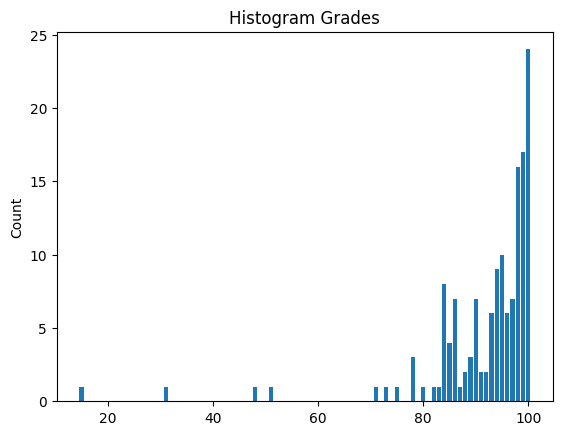

In [46]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [47]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

code  #user_prompts  #error  #no  #thank  \
0  0031c86e-81f4-4eef-9e0e-28037abf9883           14.0     3.0  1.0     0.0   
1  0225686d-b825-4cac-8691-3a3a5343df2b           18.0     0.0  0.0     0.0   
2  041f950b-c013-409a-a642-cffff60b9d4b            9.0     3.0  0.0     1.0   
3  04f91058-d0f8-4324-83b2-19c671f433dc           20.0     1.0  1.0     0.0   
4  089eb66d-4c3a-4f58-b98f-a3774a2efb34           86.0     1.0  5.0     0.0   

   #next  #entropy  prompt_avg_chars  response_avg_chars  
0    0.0       0.0          2.205748          212.206370  
1    0.0       3.0          0.304163          113.633582  
2    0.0       3.0          0.262324           17.187601  
3    0.0       3.0          0.123346          107.092566  
4    0.0      26.0          0.017986           18.850913

In [48]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

code  #user_prompts  #error  #no  #thank  \
0  0031c86e-81f4-4eef-9e0e-28037abf9883           14.0     3.0  1.0     0.0   
1  0225686d-b825-4cac-8691-3a3a5343df2b           18.0     0.0  0.0     0.0   
2  041f950b-c013-409a-a642-cffff60b9d4b            9.0     3.0  0.0     1.0   
3  04f91058-d0f8-4324-83b2-19c671f433dc           20.0     1.0  1.0     0.0   
4  089eb66d-4c3a-4f58-b98f-a3774a2efb34           86.0     1.0  5.0     0.0   

   #next  #entropy  prompt_avg_chars  response_avg_chars       Q_0       Q_1  \
0    0.0       0.0          2.205748          212.206370  0.129813  0.287018   
1    0.0       3.0          0.304163          113.633582  0.086766  0.278878   
2    0.0       3.0          0.262324           17.187601  0.021408  0.033617   
3    0.0       3.0          0.123346          107.092566  0.060687  0.060104   
4    0.0      26.0          0.017986           18.850913  0.184043  0.268752   

        Q_2       Q_3       Q_4       Q_5       Q_6       Q_7       Q_8  
0  0.193838  0.106710  0.069686  0.151696  0.016053  0.058891  0.063412  
1  0.214735  0.140940  0.104137  0.168382  0.233423  0.127030  0.229035  
2  0.080447  0.039986  0.133486  0.028385  0.066171  0.090294  0.038785  
3  0.121666  0.220324  0.173462  0.111479  0.276453  0.129554  0.137191  
4  0.264475  0.473466  0.113106  0.188264  0.219715  0.237225  0.205943

#### Merging scores with features

In [49]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

code  #user_prompts  #error  #no  #thank  \
0  0031c86e-81f4-4eef-9e0e-28037abf9883           14.0     3.0  1.0     0.0   
1  0225686d-b825-4cac-8691-3a3a5343df2b           18.0     0.0  0.0     0.0   
2  041f950b-c013-409a-a642-cffff60b9d4b            9.0     3.0  0.0     1.0   
3  04f91058-d0f8-4324-83b2-19c671f433dc           20.0     1.0  1.0     0.0   
4  089eb66d-4c3a-4f58-b98f-a3774a2efb34           86.0     1.0  5.0     0.0   

   #next  #entropy  prompt_avg_chars  response_avg_chars       Q_0       Q_1  \
0    0.0       0.0          2.205748          212.206370  0.129813  0.287018   
1    0.0       3.0          0.304163          113.633582  0.086766  0.278878   
2    0.0       3.0          0.262324           17.187601  0.021408  0.033617   
3    0.0       3.0          0.123346          107.092566  0.060687  0.060104   
4    0.0      26.0          0.017986           18.850913  0.184043  0.268752   

        Q_2       Q_3       Q_4       Q_5       Q_6       Q_7       Q_8  grade  
0  0.193838  0.106710  0.069686  0.151696  0.016053  0.058891  0.063412   48.0  
1  0.214735  0.140940  0.104137  0.168382  0.233423  0.127030  0.229035   99.0  
2  0.080447  0.039986  0.133486  0.028385  0.066171  0.090294  0.038785   90.0  
3  0.121666  0.220324  0.173462  0.111479  0.276453  0.129554  0.137191   97.0  
4  0.264475  0.473466  0.113106  0.188264  0.219715  0.237225  0.205943  100.0

In [50]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 17) (122,)


#### Train/Test split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing 

In [52]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [53]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 126.39409722222263
Node 2 has MSE 64.35004526935154
Node 3 has MSE 45.84113770378099
Node 4 has MSE 72.9333333333334
Node 5 has MSE 61.649999999999636
Node 6 has MSE 42.359375
Node 7 has MSE 6.2222222222208075
Node 8 has MSE 0.0
Node 9 has MSE 1.0
Node 10 has MSE 0.0
Node 11 has MSE 0.0
Node 12 has MSE 24.0
Node 13 has MSE 4.6875
Node 14 has MSE 0.0
Node 15 has MSE 0.0
Node 16 has MSE 0.0
Node 17 has MSE 1.0
Node 18 has MSE 0.0
Node 19 has MSE 0.0
Node 20 has MSE 55.88750000000073
Node 21 has MSE 32.620498614958706
Node 22 has MSE 16.168367346939704
Node 23 has MSE 1.0
Node 24 has MSE 0.0
Node 25 has MSE 0.0
Node 26 has MSE 8.576388888888687
Node 27 has MSE 0.9375
Node 28 has MSE 0.25
Node 29 has MSE 0.5
Node 30 has MSE 13.1875
Node 31 has MSE 0.0
Node 32 has MSE 2.888888888888687
Node 33 has MSE 21.43999999999869
Node 34 has MSE 8.75
Node 35 has MSE 0.0
Node 36 has MSE 2.66666666666697
Node 37 has MSE 0.0
Node 38 has MSE 1.0
Node 39 has

In [54]:
import graphviz

In [ ]:
# Plotting the Tree 
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

In [56]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 2.9236622484045163
MSE TEST: 74.79311224489794
R2 Train: 0.9821095574235813
R2 TEST: 0.33378423804889523
